## Incremental Deep Learning for Image Classification

This notebook implements an incremental learning approach for image classification using deep learning. The idea is to train a deep learning model on a small dataset and then incrementally train the model on new data.

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Pipeline](#data-pipeline)
3. [Model Architecture](#model-architecture)
4. [Training Pipeline](#training)
5. [Evaluation](#evaluation)
6. [Results](#results)


### 1. Setup and Imports <a id='setup'></a>

Configures logging and import required libraries


In [1]:
import json
import logging
from dataclasses import dataclass
from datetime import datetime
from itertools import cycle
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2024-11-22 12:20:12.815481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 12:20:12.829614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732299612.847480   61775 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732299612.851927   61775 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 12:20:12.866999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

#### Configuration


In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

##### Visualization


In [5]:
sns.set_theme(style="whitegrid")

## 2. Data Pipeline <a id='data-pipeline'></a>


Configures the data split object


In [6]:
@dataclass
class DataSplit:
    train_paths: List[str]
    val_paths: List[str]
    test_paths: List[str]
    class_mapping: Dict[str, int]
    num_classes: int

### Data Manager


In [7]:
class DataManager:
    def __init__(
        self,
        base_path: str,
        img_size: Tuple[int, int] = (224, 224),
        val_split: float = 0.15,
        test_split: float = 0.15,
        random_seed: int = 42,
    ):
        self.data_dir = Path(base_path)
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split

        self.seed = random_seed
        self.class_counts = self._get_class_counts()
        self.sorted_classes = self._sort_classes_by_size()
        self.class_mapping = self._create_class_mapping()

    def _get_class_counts(self) -> Dict[str, int]:
        """
        Counts the number of images in each class directory.
        """

        class_counts: dict = {}
        if not self.data_dir.exists():
            raise ValueError(f"Data directory {self.data_dir} does not exist.")

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg")))

        return class_counts

    def _sort_classes_by_size(self) -> List[str]:
        """
        Sorts the classes by the number of images in each class.

        Returns:
          List[str]: List of class names sorted by the number of images in each class.
        """

        return sorted(
            self.class_counts.keys(),
            key=lambda x: (self.class_counts[x], int(x)),
            reverse=True,
        )

    def _create_class_mapping(self) -> Dict[str, int]:
        """
        Creates a mapping from class names to class indices.

        Returns:
          Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return {class_name: int(class_name) for class_name in self.class_counts.keys()}

    def get_class_subset(self, num_classes: int) -> List[str]:
        """
        Gets the top `num_classes` classes sorted by the number of images in each class.

        Args:
          num_classes (int): Number of classes to include in the dataset.

        Returns:
          List[str]: List of class names.
        """

        if num_classes > len(self.sorted_classes):
            raise ValueError(
                f"Requested {num_classes} classes, but only {len(self.sorted_classes)} available."
            )

        return self.sorted_classes[:num_classes]

    def _collect_image_paths(self, classes: List[str]) -> Tuple[List[str], List[str]]:
        """
        Collects all image paths and their corresponding labels for the
        given classes.

        Args:
          classes (List[str]): List of class names to include in the dataset.

        Returns:
          Tuple[List[str], List[str]]: Tuple containing the image paths and their corresponding labels.
        """

        image_paths, labels = [], []

        for class_name in classes:
            class_path = self.data_dir / class_name

            if not class_path.exists():
                logger.warning(f"Class directory {class_path} does not exist.")
                continue

            image_files = []
            for ext in ["*.jpg"]:
                image_files.extend(list(class_path.glob(ext)))

            if not image_files:
                logger.warning(f"No images found in {class_path}")
                continue

            image_paths.extend([str(img) for img in image_files])
            labels.extend([class_name] * len(image_files))

            logger.info(f"Collected {len(image_files)} images for class {class_name}")

            if not image_paths:
                raise ValueError(f"No images found for classes {classes}")

        return image_paths, labels

    def prepare_data_split(self, classes: List[str]) -> DataSplit:
        """
        Prepares the data split for the given classes. It first
        divides the data into train_val and test sets, and then
        further divides the train_val set into train and validation

        Args:
            classes (List[str]): List of class names to include in the dataset.

        Returns:
            DataSplit: DataSplit object containing the train, validation, and test splits.
        """

        image_paths, labels = self._collect_image_paths(classes)
        subset_mapping = {cls: self.class_mapping[cls] for cls in classes}

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            image_paths,
            labels,
            test_size=self.test_split,
            stratify=labels,
            random_state=self.seed,
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths,
            train_val_labels,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.seed,
        )

        logger.info(
            f"Split sizes - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}"
        )

        return DataSplit(
            train_paths=train_paths,
            val_paths=val_paths,
            test_paths=test_paths,
            class_mapping=subset_mapping,
            num_classes=len(classes),
        )

    def plot_class_distribution(self, classes: Optional[List[str]] = None):
        """
        Plots the class distribution for the given classes.

        Args:
            clases (Optional[List[str]]): List of class names to include in the plot.
        """

        if classes is None:
            classes = self.sorted_classes

        counts = [self.class_counts[cls] for cls in classes]
        plt.figure(figsize=(12, 6))
        plt.bar(classes, counts)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Data Generator


In [8]:
class DataGenerator:
    def __init__(self, img_size: Tuple[int, int], batch_size: int = 32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_datagen = self._create_train_datagen()
        self.test_datagen = self._create_test_datagen()
        self.label_to_index = None
        self.num_classes = None

    def _create_train_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the training data generator with data augmentation. The following augmentations are applied:
        - Rotation
        - Width and height shift
        - Shear
        - Zoom
        - Horizontal and vertical flip
        - Brightness

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Training data generator.
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="constant",
            brightness_range=(0.6, 1.4),
            channel_shift_range=0.2,
        )

    def _create_test_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the test data generator with only the input preprocessing function.

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Test data generator
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self._preprocess_input,
        )

    def _preprocess_input(self, x):
        """
        Preprocesses the input image by scaling pixel values to the range of [-1, 1].

        Args:
            x (np.ndarray): Input image.

        Returns:
            np.ndarray: Preprocessed image.
        """

        x = tf.cast(x, tf.float32)

        return tf.image.per_image_standardization(x)

    def create_generators(self, data_split: DataSplit):
        """
        Creates the generators for training, validation, and testing.

        Args:
            data_split (DataSplit): DataSplit object containing the train, validation, and test splits.

        Returns:
            Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]: Tuple containing the training, validation, and test datasets.
        """

        self.label_to_index = data_split.class_mapping
        self.num_classes = data_split.num_classes

        def create_df(paths: List[str]) -> pd.DataFrame:
            return pd.DataFrame(
                {
                    "filename": paths,
                    "class": [Path(p).parent.name for p in paths],
                }
            )

        train_df = create_df(data_split.train_paths)
        val_df = create_df(data_split.val_paths)
        test_df = create_df(data_split.test_paths)

        logger.info(
            f"Training set class distribution:\n{train_df['class'].value_counts()}"
        )

        train_ds = self._create_dataset(train_df, is_training=True)
        val_ds = self._create_dataset(val_df, is_training=False)
        test_ds = self._create_dataset(test_df, is_training=False)

        return train_ds, val_ds, test_ds

    def _create_dataset(
        self, df: pd.DataFrame, is_training: bool = False
    ) -> tf.data.Dataset:
        """
        Creates the tf.data.Dataset object from the given DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the image paths and their corresponding labels.
            is_training (bool): Whether the dataset is for training or not.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        datagen = self.train_datagen if is_training else self.test_datagen
        filenames = df["filename"].values
        labels = df["class"].map(self.label_to_index).values

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(self.batch_size)

        if is_training:
            dataset = dataset.shuffle(
                buffer_size=len(df), reshuffle_each_iteration=True
            )

        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        steps = len(df) // self.batch_size
        if is_training:
            self.steps_per_epoch = steps

        else:
            self.validation_steps = steps

        return dataset

    @tf.function
    def _parse_function(self, filename, label):
        """
        Loads and preprocesses the image and its corresponding label.

        Args:
            filename (tf.Tensor): Image filename.
            label (tf.Tensor): Image label.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the image and its label
        """

        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.img_size)
        label = tf.one_hot(label, self.num_classes)

        return image, label

    def get_steps(self):
        return self.steps_per_epoch, self.validation_steps

    def get_num_classes(self):
        return self.num_classes

    def get_class_mapping(self):
        return self.label_to_index

## Pre-Trained Model


In [9]:
import keras

In [10]:
f1_score_metric = tf.keras.metrics.F1Score(
    average="macro", threshold=None, name="f1_score"
)


@keras.saving.register_keras_serializable()
def sparse_f1_score(y_true, y_pred):
    return f1_score_metric(y_true, y_pred)

In [11]:
@keras.saving.register_keras_serializable()
class ModelManager:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_dir: str = "models",
        initial_lr: float = 1e-4,
    ):
        self.img_size = img_size
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.initial_lr = initial_lr
        self.model = None
        self.base_model = None

    def build_model(self, num_classes: int) -> tf.keras.Model:
        if self.model is None:
            self.base_model = tf.keras.applications.MobileNetV3Large(
                weights="imagenet", include_top=False, input_shape=(*self.img_size, 3)
            )

            self.base_model.trainable = False

            inputs = tf.keras.Input(shape=(*self.img_size, 3))
            x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)

            x = self.base_model(x, training=False)
            x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
            x2 = tf.keras.layers.GlobalMaxPooling2D()(x)

            x = tf.keras.layers.Concatenate()([x1, x2])
            x = tf.keras.layers.Dense(512, use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.5)(x)

            x = tf.keras.layers.Dense(256, activation="relu")(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            self.model = tf.keras.Model(inputs, outputs)

        self.current_classes = num_classes
        self._compile_model(num_classes=num_classes)
        return self.model

    def _compile_model(self, num_classes):
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.initial_lr, clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=["accuracy", sparse_f1_score],
        )

    def train(
        self,
        train_ds,
        val_ds,
        iteration: int,
        epochs: int = 50,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(self.model_dir / f"best_model_iter_{iteration}.keras"),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                restore_best_weights=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
            ),
        ]

        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
        )

        self.model.save(str(self.model_dir / f"model_iter_{iteration}.keras"))

        return history

    def prepare_next_iteration(
        self, previous_iteration: int, new_num_classes: int
    ) -> None:
        self.load_best_model(f"{previous_iteration}")
        old_dense = self.model.layers[-1]
        old_weights = old_dense.get_weights()

        # Create new model with additional classes
        self.build_model(new_num_classes)

        # Get new dense layer
        new_dense = self.model.layers[-1]
        new_weights = new_dense.get_weights()

        # Copy old weights for existing classes
        new_weights[0][: old_weights[0].shape[0], : old_weights[0].shape[1]] = (
            old_weights[0]
        )
        new_weights[1][: old_weights[1].shape[0]] = old_weights[1]

        # Initialize new class weights with Xavier/Glorot initialization
        stddev = np.sqrt(2.0 / (new_weights[0].shape[0] + new_weights[0].shape[1]))
        new_weights[0][old_weights[0].shape[0] :, :] = np.random.normal(
            0,
            stddev,
            (
                new_weights[0].shape[0] - old_weights[0].shape[0],
                new_weights[0].shape[1],
            ),
        )
        new_weights[1][old_weights[1].shape[0] :] = 0.0

        # Set the weights
        new_dense.set_weights(new_weights)

        # Make sure to preserve training status of other layers
        for old_layer, new_layer in zip(self.model.layers[:-1], self.model.layers[:-1]):
            new_layer.set_weights(old_layer.get_weights())
            new_layer.trainable = old_layer.trainable

    def load_best_model(self, iteration: str) -> None:
        model_path = self.model_dir / f"best_model_iter_{iteration}.keras"
        if not model_path.exists():
            raise ValueError(f"No saved model found for iteration {iteration}")

        custom_objects = {"sparse_f1_score": sparse_f1_score}
        self.model = tf.keras.models.load_model(
            str(model_path), custom_objects=custom_objects
        )
        logger.info(f"Loaded best model from iteration {iteration}")

    def save_iteration_info(self, iteration: int, metrics: Dict) -> None:
        info = {
            "iteration": iteration,
            "metrics": metrics,
            "model_config": self.model.get_config(),
            "timestamp": datetime.now().isoformat(),
        }

        with open(self.model_dir / f"iteration_{iteration}_info.json", "w") as f:
            json.dump(info, f, indent=4)

    def get_config(self) -> Dict:
        return self.model.get_config()

### Auxiliary function


In [12]:
def plot_history_subplot(history):
    """Plot training history metrics."""
    fig = plt.figure(figsize=(15, 5))

    # Accuracy subplot
    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(history.history["accuracy"], label="Training")
    ax1.plot(history.history["val_accuracy"], label="Validation")
    ax1.set_title("Model Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    # Loss subplot
    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(history.history["loss"], label="Training")
    ax2.plot(history.history["val_loss"], label="Validation")
    ax2.set_title("Model Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    # F1 Score subplot
    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(history.history["sparse_f1_score"], label="Training")
    ax3.plot(history.history["val_sparse_f1_score"], label="Validation")
    ax3.set_title("Model F1 Score")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("F1 Score")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
class ModelEvaluator:
    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager
        self.evaluation_history: Dict[int, Dict] = {}

    def evaluate_iteration(
        self,
        iteration: int,
        test_ds: tf.data.Dataset,
        class_names: List[str],
        plot: bool = True,
    ) -> Dict:
        y_pred_proba = []
        y_pred = []
        y_true = []

        for images, labels in test_ds:
            predictions = self.model_manager.model.predict(images, verbose=0)

            y_pred_proba.extend(predictions)
            y_pred.extend(np.argmax(predictions, axis=1))
            y_true.extend(np.argmax(labels, axis=1))

        y_pred_proba = np.array(y_pred_proba)
        y_true_onehot = tf.one_hot(y_true, depth=len(class_names))

        assert y_pred_proba.shape[1] == len(
            class_names
        ), f"Mismatch in class dimensions: {y_pred_proba.shape[1]} != {len(class_names)}"

        cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
        report = classification_report(
            y_true, y_pred, labels=range(len(class_names)), output_dict=True
        )

        results = {
            "confusion_matrix": cm,
            "classification_report": report,
            "class_names": class_names,
            "y_true": y_true_onehot,
            "y_pred_proba": y_pred_proba,
        }

        self.evaluation_history[iteration] = results

        if plot:
            self.plot_confusion_matrix(iteration)
            self.plot_roc_curves(iteration)
            self.plot_precision_recall_curves(iteration)

        return results

    def plot_roc_curves(self, iteration: int) -> None:
        results = self.evaluation_history[iteration]
        y_true = results["y_true"]
        y_pred_proba = results["y_pred_proba"]
        class_names = results["class_names"]

        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))

        for i, (color, class_name) in enumerate(zip(colors, class_names)):
            try:
                fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(
                    fpr,
                    tpr,
                    color=color,
                    lw=2,
                    label=f"ROC curve {class_name} (AUC = {roc_auc:.2f})",
                )
            except Exception as e:
                print(f"Warning: Could not plot ROC curve for class {class_name}: {e}")

        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves - Iteration {iteration}")
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curves(self, iteration: int) -> None:
        results = self.evaluation_history[iteration]
        y_true = results["y_true"]
        y_pred_proba = results["y_pred_proba"]
        class_names = results["class_names"]

        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))

        for i, (color, class_name) in enumerate(zip(colors, class_names)):
            try:
                precision, recall, _ = precision_recall_curve(
                    y_true[:, i], y_pred_proba[:, i]
                )
                avg_precision = average_precision_score(
                    y_true[:, i], y_pred_proba[:, i]
                )
                plt.plot(
                    recall,
                    precision,
                    color=color,
                    lw=2,
                    label=f"PR curve {class_name} (AP = {avg_precision:.2f})",
                )
            except Exception as e:
                print(f"Warning: Could not plot PR curve for class {class_name}: {e}")

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curves - Iteration {iteration}")
        plt.legend(loc="lower left")
        plt.show()

    def plot_confusion_matrix(
        self, iteration: int, figsize: Tuple[int, int] = (20, 8), cmap: str = "Blues"
    ) -> None:
        results = self.evaluation_history[iteration]
        cm = results["confusion_matrix"]
        class_names = results["class_names"]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Normalized matrix
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1,
        )
        ax1.set_title(f"Normalized Confusion Matrix - Iteration {iteration}")
        ax1.set_ylabel("True Label")
        ax1.set_xlabel("Predicted Label")
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

        # Raw counts matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax2,
        )
        ax2.set_title(f"Raw Counts Confusion Matrix - Iteration {iteration}")
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.show()

    def print_classification_report(self, iteration: int) -> None:
        report = self.evaluation_history[iteration]["classification_report"]
        class_names = self.evaluation_history[iteration]["class_names"]

        print(f"\nClassification Report - Iteration {iteration}")
        print("-" * 60)

        # Print metrics for each class
        for i, class_name in enumerate(class_names):
            if str(i) in report:
                metrics = report[str(i)]
                print(
                    f"{class_name::<15} Precision: {metrics['precision']:.3f}  "
                    f"Recall: {metrics['recall']:.3f}  "
                    f"F1-score: {metrics['f1-score']:.3f}"
                )

        # Print overall metrics
        print("-" * 60)
        print(f"Accuracy: {report['accuracy']:.3f}")
        print(f"Macro avg F1-Score: {report['macro avg']['f1-score']:.3f}")
        print(f"Weighted avg F1-Score: {report['weighted avg']['f1-score']:.3f}")

In [14]:
def compare_iterations_performance(evaluator, iterations=[1, 2]):
    plt.figure(figsize=(15, 6))

    for iteration in iterations:
        if iteration in evaluator.evaluation_history:
            report = evaluator.evaluation_history[iteration]["classification_report"]
            classes = evaluator.evaluation_history[iteration]["class_names"]

            f1_scores = []
            accuracies = []
            for class_name in classes:
                class_idx = str(classes.index(class_name))
                if class_idx in report:
                    f1_scores.append(report[class_idx]["f1-score"])
                    accuracies.append(report[class_idx]["precision"])

            plt.subplot(1, 2, 1)
            plt.plot(
                range(len(classes)),
                f1_scores,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("F1 Score")
            plt.title("F1 Score by Class")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(
                range(len(classes)),
                accuracies,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("Precision")
            plt.title("Precision by Class")
            plt.legend()

    plt.tight_layout()
    plt.show()

## Main Execution


In [15]:
dataset_manager = DataManager(
    base_path="../../../data/extended/day/", img_size=(224, 224)
)

data_generator = DataGenerator(img_size=(224, 224), batch_size=32)
model_manager = ModelManager(img_size=(224, 224), model_dir="saved_models")

In [16]:
evaluator = ModelEvaluator(model_manager)

## First Execution


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


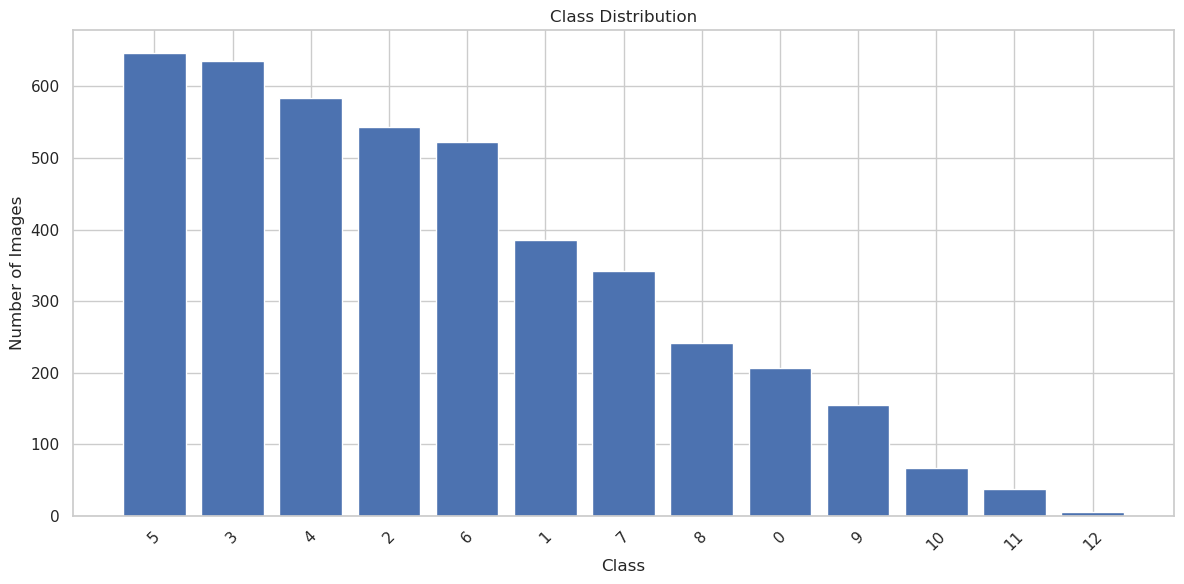

In [17]:
dataset_manager.plot_class_distribution()

## Train Iteratively


In [18]:
def prepare_next_iteration(
    model_manager, previous_iteration: int, new_num_classes: int
):
    """
    Prepares the next iteration of the model by loading the best model
    from the previous iteration and building a new model with the updated
    weights.

    Args:
        model_manager (ModelManager): ModelManager object.
        previous_iteration (int): Previous iteration number.
        new_num_classes (int): Number of classes in the new iteration.
    """

    model_path = model_manager.model_dir / f"best_model_iter_{previous_iteration}.keras"

    if not model_path.exists():
        not ValueError(f"No saved model found for iteration {previous_iteration}")

    custom_objects = {
        "sparse_f1_score": sparse_f1_score,
    }

    model_manager.model = tf.keras.models.load_model(
        str(model_manager.model_dir / f"best_model_iter_{previous_iteration}.keras"),
        custom_objects=custom_objects,
    )

    old_weights = [layer.get_weigths() for layer in model_manager.model.layers[:-1]]
    model_manager.build_model(new_num_classes)

    for layer, weights in zip(model_manager.model.layers[:-1], old_weights):
        if weights:
            layer.set_weights(weights)

In [19]:
def calculate_balanced_weights(dataset_manager, current_classes, previous_classes=None):
    total_samples = sum(dataset_manager.class_counts[cls] for cls in current_classes)

    weights = {}

    for cls in current_classes:
        base_weight = total_samples / (
            len(current_classes) * dataset_manager.class_counts[cls]
        )

        if previous_classes and cls in previous_classes:
            weights[int(cls)] = base_weight * 1.5

        else:
            weights[int(cls)] = base_weight

    return weights

In [20]:
def train_iteratively(
    dataset_manager,
    model_manager,
    data_generator,
    evaluator,
    initial_class_count=7,
    final_classes_count=13,
    classes_per_iteration=2,
    epochs=100,
):
    classes_trained = initial_class_count
    iteration = 1
    previous_classes = []

    while classes_trained <= final_classes_count:
        print(f"\n{'='*20} Iteration {iteration} {'='*20}")
        current_classes = dataset_manager.get_class_subset(num_classes=classes_trained)

        new_classes = [cls for cls in current_classes if cls not in previous_classes]
        print(f"Previous classes: {previous_classes}")
        print(f"New classes: {new_classes}")

        data_split = dataset_manager.prepare_data_split(current_classes)
        train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

        total_samples = sum(
            dataset_manager.class_counts[cls] for cls in current_classes
        )

        class_weights = {}
        for cls in current_classes:
            base_weight = total_samples / (
                len(current_classes) * dataset_manager.class_counts[cls]
            )

            if cls in new_classes:
                class_weights[int(cls)] = base_weight * 2.0

            else:
                class_weights[int(cls)] = base_weight

        if iteration == 1:
            model = model_manager.build_model(len(current_classes))

        else:
            model_manager.prepare_next_iteration(iteration - 1, len(current_classes))

            for layer in model_manager.model.layers[-5:]:
                layer.trainable = True

        history = model_manager.train(
            train_gen,
            val_gen,
            iteration=iteration,
            epochs=epochs,
            class_weights=class_weights,
        )

        plot_history_subplot(history)
        evaluation_results = evaluator.evaluate_iteration(
            iteration=iteration, test_ds=test_gen, class_names=current_classes
        )

        evaluator.print_classification_report(iteration=iteration)

        if iteration > 1:
            unfreeze_layers = min(
                5 * (iteration - 1), len(model_manager.base_model.layers)
            )

            for layer in model_manager.base_model.layers[-unfreeze_layers:]:
                layer.trainable = True

            compare_iterations_performance(evaluator, [iteration - 1, iteration])

        previous_classes = current_classes.copy()
        classes_trained += classes_per_iteration
        iteration += 1

        model_manager.save_iteration_info(
            iteration, evaluation_results["classification_report"]
        )

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Split sizes - Train: 2559, Val: 549, Test: 549
INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
Name: count, dtype: int64



==================== Iteration 1 ====================
Previous classes: []
New classes: ['5', '3', '4', '2', '6', '1', '7']


I0000 00:00:1732299615.714927   61775 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/100


I0000 00:00:1732299632.546526   61852 service.cc:148] XLA service 0x7fcfcc0033f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732299632.546574   61852 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-22 12:20:32.722495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732299633.746131   61852 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1732299640.202229   61852 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732299640.415361   61852 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732299640.638

 1/80 ━━━━━━━━━━━━━━━━━━━━ 33:09 25s/step - accuracy: 0.1250 - loss: 4.7985 - sparse_f1_score: 0.0658

I0000 00:00:1732299644.589861   61852 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1732299651.414706   61849 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732299651.635609   61849 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732299651.856176   61849 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1684 - loss: 4.5500 - sparse_f1_score: 0.0966

2024-11-22 12:21:05.059444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 12:21:09.613680: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 12:21:09.764869: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1786', 4 bytes spill stores, 4 bytes spill loads

2024-11-22 12:21:10.084691: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1732299673.971545   61852 gpu_timer.cc:82] Delay kerne


Epoch 1: val_accuracy improved from -inf to 0.26958, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 58s 418ms/step - accuracy: 0.1695 - loss: 4.5326 - sparse_f1_score: 0.0974 - val_accuracy: 0.2696 - val_loss: 1.6705 - val_sparse_f1_score: 0.2029 - learning_rate: 1.0000e-04
Epoch 2/100
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2963 - loss: 2.7604 - sparse_f1_score: 0.2194
Epoch 2: val_accuracy improved from 0.26958 to 0.37158, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.2977 - loss: 2.7552 - sparse_f1_score: 0.2199 - val_accuracy: 0.3716 - val_loss: 1.2268 - val_sparse_f1_score: 0.2563 - learning_rate: 1.0000e-04
Epoch 3/100
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3472 - loss: 2.4144 - sparse_f1_score: 0.2650
Epoch 3: val_accuracy improved from 0.37158 to 0.39709, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accurac

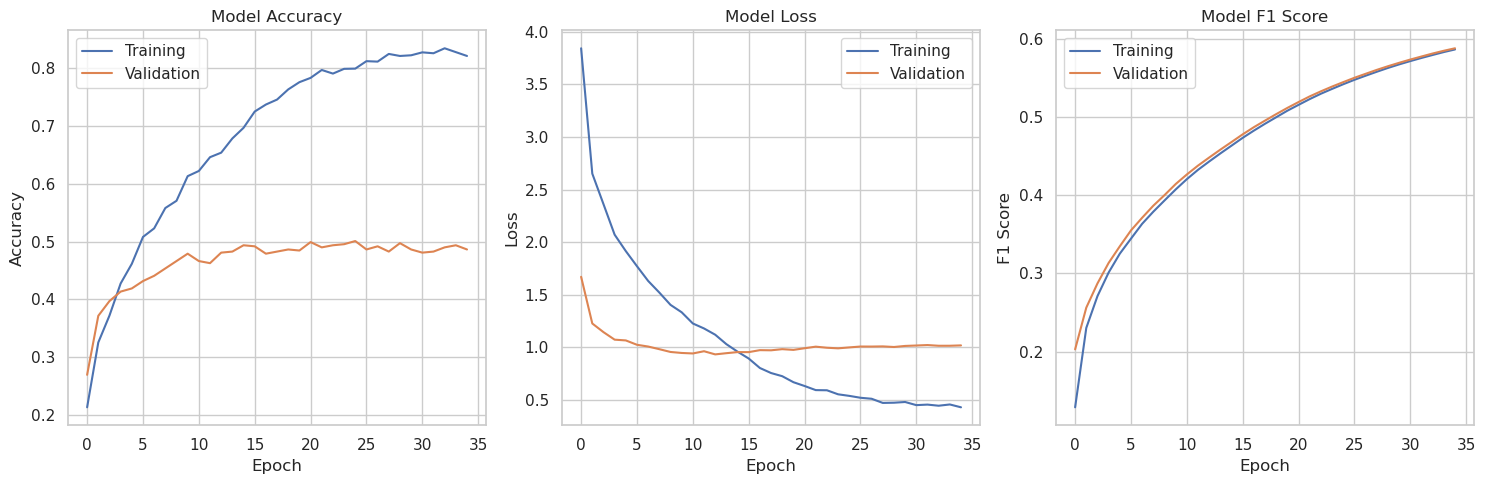

2024-11-22 12:24:10.865939: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-11-22 12:24:25.053173: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

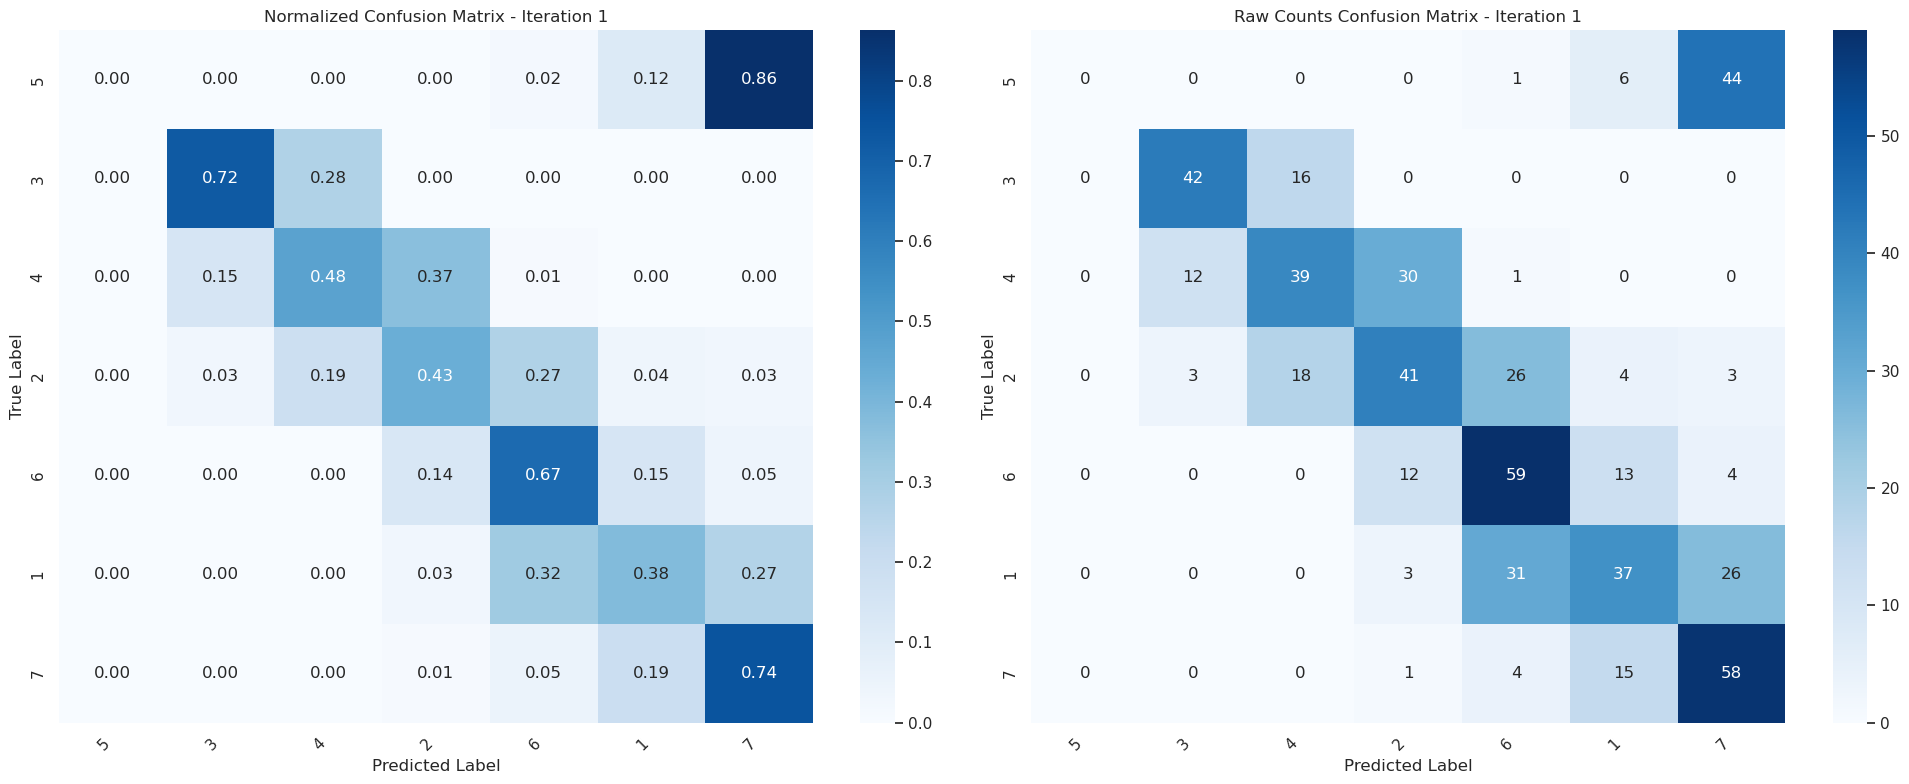

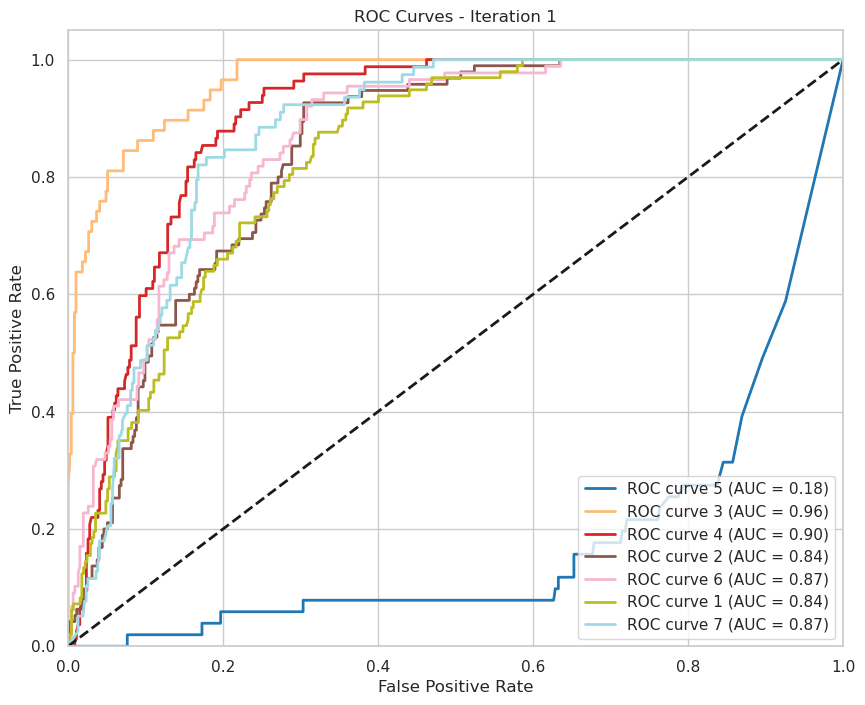

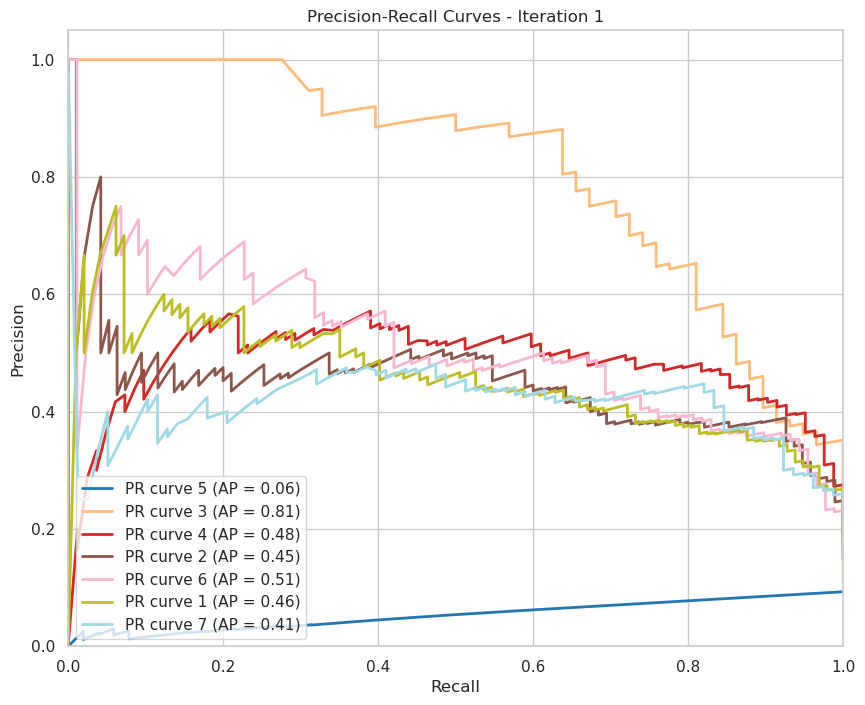

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Split sizes - Train: 2872, Val: 616, Test: 616
INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
8    169
0    144
Name: count, dtype: int64



Classification Report - Iteration 1
------------------------------------------------------------
5:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
3:::::::::::::: Precision: 0.737  Recall: 0.724  F1-score: 0.730
4:::::::::::::: Precision: 0.534  Recall: 0.476  F1-score: 0.503
2:::::::::::::: Precision: 0.471  Recall: 0.432  F1-score: 0.451
6:::::::::::::: Precision: 0.484  Recall: 0.670  F1-score: 0.562
1:::::::::::::: Precision: 0.493  Recall: 0.381  F1-score: 0.430
7:::::::::::::: Precision: 0.430  Recall: 0.744  F1-score: 0.545
------------------------------------------------------------
Accuracy: 0.503
Macro avg F1-Score: 0.460
Weighted avg F1-Score: 0.474

==================== Iteration 2 ====================
Previous classes: ['5', '3', '4', '2', '6', '1', '7']
New classes: ['8', '0']


INFO:__main__:Loaded best model from iteration 1


Epoch 1/100
19/90 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5583 - loss: 4.6656 - sparse_f1_score: 0.5875

E0000 00:00:1732299898.793784   61849 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732299899.035904   61849 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5759 - loss: 4.1296 - sparse_f1_score: 0.5873

2024-11-22 12:25:15.031547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1786', 4 bytes spill stores, 4 bytes spill loads

2024-11-22 12:25:15.143511: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 12:25:15.869763: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1732299919.825362   61850 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732299920.046984   61850 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-


Epoch 1: val_accuracy improved from -inf to 0.51299, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.5760 - loss: 4.1132 - sparse_f1_score: 0.5873 - val_accuracy: 0.5130 - val_loss: 1.4273 - val_sparse_f1_score: 0.5863 - learning_rate: 1.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6020 - loss: 1.1836 - sparse_f1_score: 0.5992
Epoch 2: val_accuracy improved from 0.51299 to 0.64448, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6020 - loss: 1.1801 - sparse_f1_score: 0.5994 - val_accuracy: 0.6445 - val_loss: 0.5979 - val_sparse_f1_score: 0.6497 - learning_rate: 1.0000e-04
Epoch 3/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6489 - loss: 0.5317 - sparse_f1_score: 0.6609
Epoch 3: val_accuracy improved from 0.64448 to 0.71266, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accurac

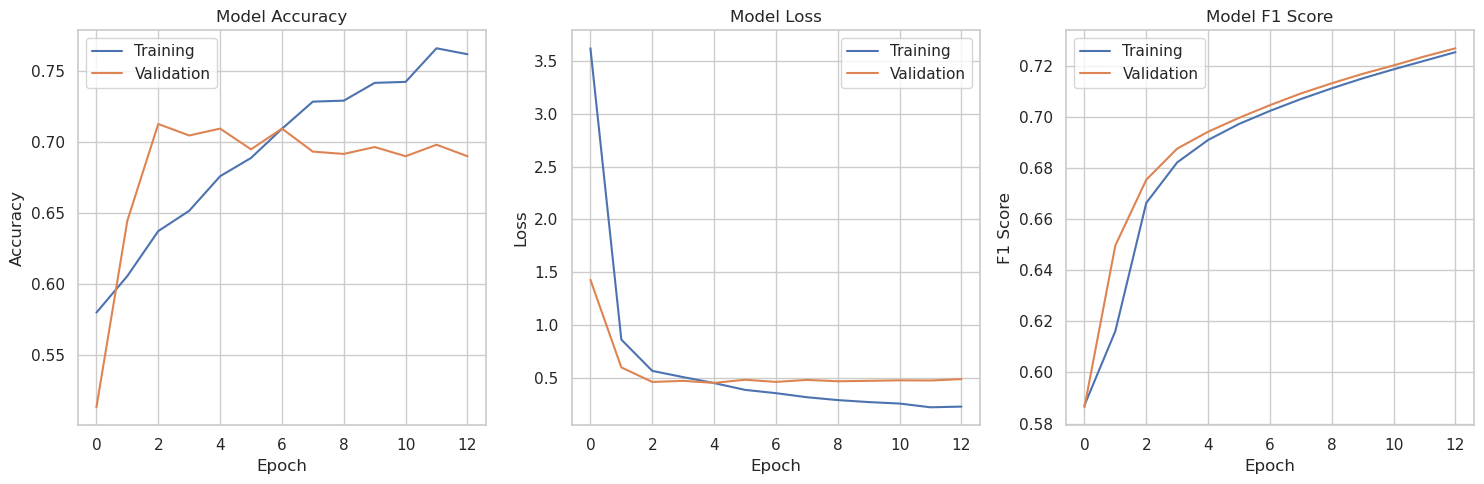

2024-11-22 12:26:39.350515: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


AssertionError: Mismatch in class dimensions: 7 != 9

In [21]:
train_iteratively(
    dataset_manager=dataset_manager,
    model_manager=model_manager,
    data_generator=data_generator,
    evaluator=evaluator,
    initial_class_count=7,
    final_classes_count=13,
    classes_per_iteration=2,
    epochs=100,
)